In [1]:
%matplotlib inline
# %matplotlib qt
import hyperspy.api as hs
import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
import matplotlib
from snmfem.models import edxs
import snmfem.spectrum_fitting as sf
from snmfem.conf import DATASETS_PATH
from pathlib import Path
from snmfem.estimators import NMF
from snmfem.datasets import spim

# Guide to this notebook

Every time the symbol ⚠️ appears, a user input is required in the cell below.

If a cell made a few windows pop up, please kill the windows once you're done. Otherwise every new plot will be displayed in top of the other (which may slow your computer down). 

Overview of the different steps :
- I. Load the data either a spectrum (go to step III.) or a spectrum image
- II. Select an area of interest in your spectrum image.
- III. Creates an energy scale (x) from your data for the fitting procedure.
- IV. Selects the regions of the spectrum were there are no peaks for background fitting.
- V. Creates the required objects (partial x and y) for the background fitting procedure.
- VI. Fitting the background. If this is not satisfactory go back to IV.

## I. Load spectrum & energy scale

The spectrum is expected to be an average spectrum, its energy range is expected to start above 0.0

⚠️

In [2]:
input_filename = str(DATASETS_PATH / Path("selected_spectrum.hspy"))
spectrum = hs.load(input_filename)

offset = spectrum.axes_manager[0].offset
scale = spectrum.axes_manager[0].scale
size = spectrum.axes_manager[0].size

x = np.linspace(offset,size*scale+offset,num = size)

# II. Select areas for bckgd fitting

⚠️ Input in the ``span_number`` the number of selection areas you wish to use. Once you execute the cell, a window will pop with a few green areas and a red spectrum. The green areas correspond to the regions were the background will be fitted. You can, drag, enlarge and reduce these green areas.

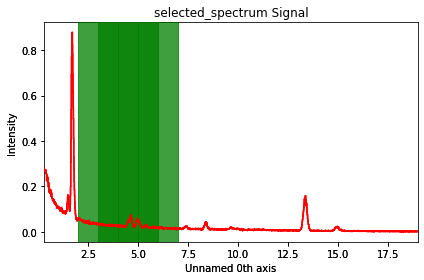

In [3]:
span_number = 4


def selection_areas(number,spectrum,scale) :
    spectrum.plot()
    roi_list = []
    for i in range(number) :
        roi_list.append(hs.roi.SpanROI(i+200*scale,i+400*scale))
        roi_list[-1].interactive(spectrum)
    return roi_list

spans = selection_areas(span_number,spectrum,scale)

Once you are satisfied with the selected areas, save their positions using the cell below

In [4]:
list_energies = [[roi.left,roi.right] for roi in spans]

# III. Fitting the continuum

⚠️ Input the sample parameters below and execute the cell to fit

In [5]:
thickness = 100e-7
density = 5.5
take_off_angle = 35
elements_dict = {"Si" : 0.25, "Mg" : 0.20, "Fe" : 0.05, "O" : 0.5}
detector = "SDD_efficiency.txt"

#################################################################################################
# For a custom detector, uncomment below and replace "SDD_efficiency.txt" with the dictionnary. #
#################################################################################################

# {"detection" : {
#     "thickness" : 450e-4,
#     "elements_dict" : {
#         "Si" : 1.0
#     }
# },"layer" : {
#     "thickness" : 10e-7,
#     "elements_dict" : {
#         "Si" : 0.33,
#         "O" : 0.66,
#         "Al" : 1.0
#     }
# }}

part_x, part_y, sum_boola = sf.make_partial_xy(list_energies,spectrum,x)

example = {
    "b0" : 1.0,
    "b1" : 1.0,
    "params_dict" : {
    "Det" : detector,
    'Abs' : {
        "thickness" : thickness,
        "toa" : take_off_angle,
        "density" : density,
        "atomic_fraction" : True},
        "elements_dict" : elements_dict
    }
}

pars = sf.ndict_to_params(example)

#################################################################################################
# You can uncomment the lines below if you want to add constraints to the absorption parameters #
#################################################################################################

# pars["params_dict__Abs__thickness"].vary = False
# pars["params_dict__Abs__thickness"].max = 5000e-7
# pars["params_dict__Det__layer__thickness"].vary = False
pars["params_dict__Abs__toa"].vary = False
pars["params_dict__Abs__density"].vary = False

out = lm.minimize(sf.residual, pars, args=(part_x,), kws={'data': part_y})
print(lm.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 800
    # variables        = 4
    chi-square         = 0.08058265
    reduced chi-square = 1.0123e-04
    Akaike info crit   = -7354.46693
    Bayesian info crit = -7335.72848
##  Warning: uncertainties could not be estimated:
    params_dict__Abs__thickness:        at boundary
    params_dict__Abs__atomic_fraction:  at initial value
[[Variables]]
    b0:                                 2.09481867 (init = 1)
    b1:                                 0.08939063 (init = 1)
    params_dict__Abs__thickness:        1.1226e-09 (init = 1e-05)
    params_dict__Abs__toa:              35 (fixed)
    params_dict__Abs__density:          5.5 (fixed)
    params_dict__Abs__atomic_fraction:  1.00000000 (init = 1)
    params_dict__elements_dict__Si:     0.25 (fixed)
    params_dict__elements_dict__Mg:     0.2 (fixed)
    params_dict__elements_dict__Fe:     0.05 (fixed)
    params_dict__elements_dict_

### Plotting the results

The red curves corresponds to the background model, the black one to the data, and the grey area correspond to the selected green areas

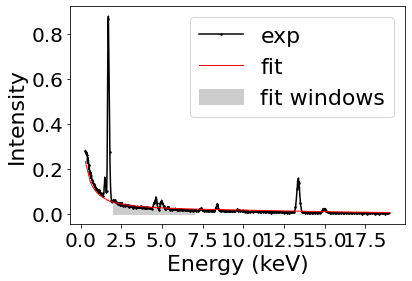

In [6]:
y = spectrum.data
bkgd = sf.residual(out.params,x)
plt.plot(x,y,"ko-",markersize=1.5,label="exp",markevery=10)
plt.fill_between(x,0,y,where=sum_boola,label="fit windows",color="0.8")
plt.xlabel("Energy (keV)",fontsize=22)
plt.xticks(fontsize=20)
# plt.ylim(0,1)
plt.yticks(fontsize=20)
plt.ylabel("Intensity",fontsize=22)
plt.plot(x,bkgd,"r-",linewidth=1,label="fit")
plt.legend(fontsize=22)

# VI. Select the interesting part of the spectrum

⚠️ A window will pop up with a red spectrum and a green area. With the green areas, you can select the energy range you want to quantify. Usually the low energy region (below 1keV) is not very well fitted by the background model. Hence you probably want to avoid the quantification of low energy characteristic X rays. 

<EDXSsnmfem, title: , dimensions: (|200)>

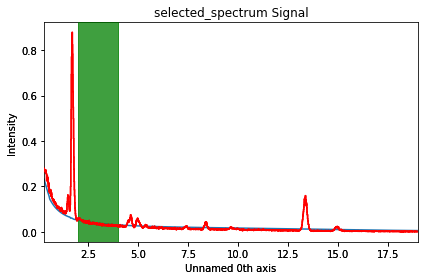

In [7]:
s_bkgd = hs.signals.Signal1D(bkgd)
s_bkgd.axes_manager[0].offset = offset
s_bkgd.axes_manager[0].scale = scale

spectrum.plot()
ax = spectrum._plot.signal_plot.ax
ax.add_line(matplotlib.lines.Line2D(spectrum._plot.axis.axis,bkgd.data))
roi = hs.roi.SpanROI(200*scale,400*scale)
roi.interactive(spectrum)

### Accepting the choice of quantification energy range

In [8]:
charac_xrays = (spectrum.isig[roi.left:roi.right].data - s_bkgd.isig[roi.left:roi.right].data).clip(min=0)
new_offset = spectrum.isig[roi.left:roi.right].axes_manager[0].offset
new_size = spectrum.isig[roi.left:roi.right].axes_manager[0].size

# VIII. Fitting the characteristic Xrays

### Initialisation of the characteristic Xray model
⚠️ Put the list of elements (by atomic numbers) you want to quantify in ``elt_list``. 

``G_calib`` is a small offset you may want to add so that the peaks are at the right energy. 

Note that depending on the energy range you chose, not all the elements you put are fitted (e.g. Oxygen will not be taken into account if your energy range starts at 1 keV)

In [9]:
elt_list = ["Si", "Mg", "Fe", "O"]
G_calib = -0.005
db = "default_xrays.json"

params_dict = {
    "Abs" : {
        "thickness" : thickness,
        "density" : density,
        "toa" : take_off_angle
    },
    "Det" : detector
}

true_elt_list = []
for elt in elt_list : 
    mod_t = edxs.EDXS(new_offset,new_size,scale,{},db_name = db)
    mod_t.generate_g_matr(elements = [elt],norm=False, g_type = "no_brstlg")
    G_t = mod_t.G
    if G_t.shape[1] == 1 : 
        true_elt_list.append(elt)
    
mod = edxs.EDXS(new_offset + G_calib,new_size,scale,params_dict,db_name = db)
mod.generate_g_matr(elements = true_elt_list,norm=False, g_type = "no_brstlg")
G = mod.G
new_x = np.linspace(new_offset,new_size*scale+new_offset,num = new_size)
print("List of elements with Xray lines in the energy range :")
print(true_elt_list)

No peak is present in the energy range for element : 14
No peak is present in the energy range for element : 12
No peak is present in the energy range for element : 26
No peak is present in the energy range for element : 8
List of elements with Xray lines in the energy range :
[]


### Fitting the characteristic Xrays

In [10]:
estimator = NMF(G=G,n_components= 1,max_iter=2000,force_simplex = True,tol = 1e-8,hspy_comp = False)
estimator.fit_transform(charac_xrays[:,np.newaxis], A=np.array([1])[:,np.newaxis])
P = estimator.P_

exits because of relative change rel_A -5.820766033477894e-11 or rel_P 5.729174835825121e-11 < tol 
Stopped after 1 iterations in 0.0 minutes and 0.0 seconds.


# IX. Plot the results

⚠️ The popping window will display the bkgd substracted experimental spectrum, the fitted characteristic Xrays model in black and red. Every element composing the model will be displayed with an offset : ``components_offset``. You can change its value below. 

If you want to display the names of the lines of an element that was used for quantification execute the next cells below before kill the window.

In [11]:
components_offset = -0.1

IndexError: list index out of range

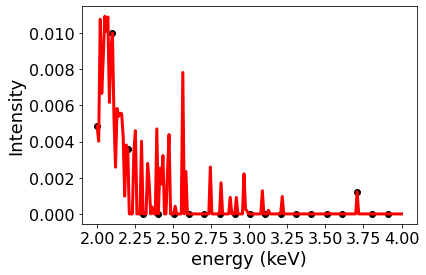

In [12]:
linestyles = [":","--","-."]

plt.plot(new_x,charac_xrays,"ko-",label="exp",markevery = 10)
plt.plot(new_x,G@P,"r",linewidth = 3,label="theo")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("energy (keV)",fontsize = 18)
plt.ylabel("Intensity", fontsize = 18)

for i in range(G.shape[1]) :
    ls_string = linestyles[i%len(linestyles)] + "C{}".format(i%9)
    plt.plot(new_x,G[:,i]*P[i]+components_offset,ls_string,label=str(true_elt_list[i]),linewidth=3)


plt.legend(fontsize=18)
plt.tight_layout()

# X. Printing the concentrations

Full summary of normalized concentrations.

In [13]:
r = P/P.sum(axis=0)
for i in range(P.shape[0]) :
    print("Z : ",true_elt_list[i],"  rel conc : ",r[i])

IndexError: list index out of range

⚠️ You can remove some elements of the results, normalizing on the remaining elements.

In [14]:
ignored_elts = ["Mg"]

inds = [true_elt_list.index(elt) for elt in ignored_elts]
remain_elt_list = [v for i,v in enumerate(true_elt_list) if i not in frozenset(inds)] 
remain_P = np.delete(P, inds, axis=0)
r = remain_P / remain_P.sum(axis=0)
for i in range(r.shape[0]) :
    print("Z : ",remain_elt_list[i],"  rel conc : ",r[i])

ValueError: 'Mg' is not in list

# VI. Select the interesting part of the spectrum

⚠️ A window will pop up with a red spectrum and a green area. With the green areas, you can select the energy range you want to quantify. Usually the low energy region (below 1keV) is not very well fitted by the background model. Hence you probably want to avoid the quantification of low energy characteristic X rays. 

<EDXSsnmfem, title: , dimensions: (|200)>

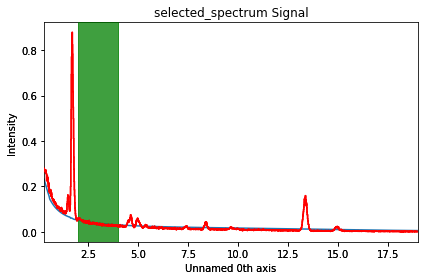

In [15]:
s_bkgd = hs.signals.Signal1D(bkgd)
s_bkgd.axes_manager[0].offset = offset
s_bkgd.axes_manager[0].scale = scale

spectrum.plot()
ax = spectrum._plot.signal_plot.ax
ax.add_line(matplotlib.lines.Line2D(spectrum._plot.axis.axis,bkgd.data))
roi = hs.roi.SpanROI(200*scale,400*scale)
roi.interactive(spectrum)

In [16]:
charac_xrays = (spectrum.isig[roi.left:roi.right].data - s_bkgd.isig[roi.left:roi.right].data).clip(min=0)
new_offset = spectrum.isig[roi.left:roi.right].axes_manager[0].offset
new_size = spectrum.isig[roi.left:roi.right].axes_manager[0].size

⚠️ If you want to fix the values of P you obtained in a previous fit put them in ``fixed_elts`` and execute the two following cells. 

For a two steps quantification : Chose a first energy range. Perform a first fit, which initialise P with all the elements. Then go back to the energy range selection, ignore the cell above, chose the fixed elements and perform the fit with fixed elements below. 

In [21]:
print("Previous Values for P")
for i,elt in enumerate(true_elt_list) : 
    print(elt, " : ", P[i])

Previous Values for P


In [19]:
fixed_elts = {"p1" : {"Cl" : 4.26588157e+18}}

dummy_spim = spim.EDXSsnmfem(np.array([1]))
dummy_spim.add_elements(elements = true_elt_list)
dummy_spim.problem_type = "no_brstlg"

fixed_P = dummy_spim.set_fixed_P(fixed_elts)

In [20]:
estimator = NMF(G=G,n_components= 1,max_iter=2000,force_simplex = True,tol = 1e-8,hspy_comp = False,fixed_P = fixed_P)
estimator.fit_transform(charac_xrays[:,np.newaxis], A=np.array([1])[:,np.newaxis])
new_P = estimator.P_

exits because of relative change rel_A -5.820766033477894e-11 or rel_P 5.729174835825121e-11 < tol 
Stopped after 1 iterations in 0.0 minutes and 0.0 seconds.


In [ ]:
r = new_P/new_P.sum(axis=0)
for i in range(new_P.shape[0]) :
    print("Z : ",true_elt_list[i],"  rel conc : ",r[i])

In [ ]:
ignored_elts = ["Mg"]

inds = [true_elt_list.index(elt) for elt in ignored_elts]
remain_elt_list = [v for i,v in enumerate(true_elt_list) if i not in frozenset(inds)] 
remain_P = np.delete(new_P, inds, axis=0)
r = remain_P / remain_P.sum(axis=0)
for i in range(r.shape[0]) :
    print("Z : ",remain_elt_list[i],"  rel conc : ",r[i])